In [10]:
import json
import os
from collections import defaultdict
import numpy as np

In [6]:
fine_labels = [
    'apple',  # id 0
    'aquarium_fish',
    'baby',
    'bear',
    'beaver',
    'bed',
    'bee',
    'beetle',
    'bicycle',
    'bottle',
    'bowl',
    'boy',
    'bridge',
    'bus',
    'butterfly',
    'camel',
    'can',
    'castle',
    'caterpillar',
    'cattle',
    'chair',
    'chimpanzee',
    'clock',
    'cloud',
    'cockroach',
    'couch',
    'crab',
    'crocodile',
    'cup',
    'dinosaur',
    'dolphin',
    'elephant',
    'flatfish',
    'forest',
    'fox',
    'girl',
    'hamster',
    'house',
    'kangaroo',
    'computer_keyboard',
    'lamp',
    'lawn_mower',
    'leopard',
    'lion',
    'lizard',
    'lobster',
    'man',
    'maple_tree',
    'motorcycle',
    'mountain',
    'mouse',
    'mushroom',
    'oak_tree',
    'orange',
    'orchid',
    'otter',
    'palm_tree',
    'pear',
    'pickup_truck',
    'pine_tree',
    'plain',
    'plate',
    'poppy',
    'porcupine',
    'possum',
    'rabbit',
    'raccoon',
    'ray',
    'road',
    'rocket',
    'rose',
    'sea',
    'seal',
    'shark',
    'shrew',
    'skunk',
    'skyscraper',
    'snail',
    'snake',
    'spider',
    'squirrel',
    'streetcar',
    'sunflower',
    'sweet_pepper',
    'table',
    'tank',
    'telephone',
    'television',
    'tiger',
    'tractor',
    'train',
    'trout',
    'tulip',
    'turtle',
    'wardrobe',
    'whale',
    'willow_tree',
    'wolf',
    'woman',
    'worm',
]

mapping_coarse_fine = {
    'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
    'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
    'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
    'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
    'fruit and vegetables': ['apple', 'mushroom', 'orange', 'pear',
                             'sweet_pepper'],
    'household electrical device': ['clock', 'computer_keyboard', 'lamp',
                                    'telephone', 'television'],
    'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
    'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
    'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
    'large man-made outdoor things': ['bridge', 'castle', 'house', 'road',
                                      'skyscraper'],
    'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain',
                                     'sea'],
    'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee',
                                       'elephant', 'kangaroo'],
    'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
    'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
    'people': ['baby', 'boy', 'girl', 'man', 'woman'],
    'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
    'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
    'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree',
              'willow_tree'],
    'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
    'vehicles 2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor'],
}

fine_id = dict()
# id of fine label -> fine label name
id_fine = dict()
for id, label in enumerate(fine_labels):
    fine_id[label] = id
    id_fine[id] = label

# coarse label name -> id of coarse label
coarse_id = dict()
# id of coarse label -> name of the coarse label
id_coarse = dict()
# name of fine label -> name of coarse label
fine_coarse = dict()
# id of fine label -> id of coarse label
fine_id_coarse_id = dict()
# id of coarse label -> id of fine label
coarse_id_fine_id = dict()
for id, (coarse, fines) in enumerate(mapping_coarse_fine.items()):
    coarse_id[coarse] = id
    id_coarse[id] = coarse
    fine_labels_ids = []
    for fine in fines:
        fine_coarse[fine] = coarse
        fine_label_id = fine_id[fine]
        fine_id_coarse_id[fine_label_id] = id
        fine_labels_ids.append(fine_label_id)
    coarse_id_fine_id[id] = fine_labels_ids

In [2]:
def read_dir(data_dir):
    clients = []
    cluster_ids = {}
    groups = []
    data = defaultdict(lambda : None)

    files = os.listdir(data_dir)
    files = [f for f in files if f.endswith('.json')]
    for f in files:
        file_path = os.path.join(data_dir,f)
        with open(file_path, 'r') as inf:
            cdata = json.load(inf)
        clients.extend(cdata['users'])
        if 'cluster_ids' in cdata:
            for idx, u in enumerate(cdata['users']):
                cluster_ids[u] = cdata['cluster_ids'][idx]
        if 'hierarchies' in cdata:
            groups.extend(cdata['hierarchies'])
        data.update(cdata['user_data'])

    clients = list(sorted(data.keys()))
    # If there are no cluser_ids in the data, assign 0 for each user
    cluster_ids = [cluster_ids[c] if c in cluster_ids else 0 for c in clients]
    return clients, cluster_ids, groups, data

def read_data(train_data_dir, test_data_dir):
    '''parses data in given train and test data directories

    assumes:
    - the data in the input directories are .json files with
        keys 'users', 'user_data' and 'cluster_ids'
    - the set of train set users is the same as the set of test set users

    Returns:
        clients: list of client ids
        groups: list of group ids; empty list if none found
        train_data: dictionary of train data
        test_data: dictionary of test data
    '''
    train_clients, train_cluster_ids, train_groups, train_data = read_dir(train_data_dir)
    test_clients, test_cluster_ids, test_groups, test_data = read_dir(test_data_dir)

    assert train_clients == test_clients
    assert train_groups == test_groups
    assert train_cluster_ids == test_cluster_ids

    # Todo return groups if required
    return train_clients, train_cluster_ids, train_data, test_data

In [3]:
data_dir = '../../.././data/cifar100/'

In [4]:
train_clients, train_cluster_ids, train_data, test_data = read_data(f'{data_dir}train/', f'{data_dir}test/')

In [5]:
full_data = {user: {key: train_data[user][key] + test_data[user][key] for key in train_data[user].keys()} for user in train_data.keys()}

In [7]:
cluster_labels = {user: [fine_id_coarse_id[label] for label in full_data[user]['y']] for user in full_data.keys()}

In [8]:
train_cluster_ids_dict = {user: train_cluster_ids[i] for i, user in enumerate(cluster_labels.keys())}

In [11]:
for user in cluster_labels.keys():
    train_counts = np.bincount(cluster_labels[user], minlength=20)
    other_user_clusters = np.argwhere(train_counts == np.amax(train_counts)).flatten()
    if train_cluster_ids_dict[user] not in other_user_clusters:
        print(f'{user}: {train_cluster_ids_dict[user]} vs. {other_user_clusters}')

apple


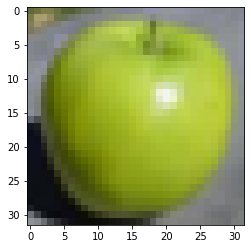

camel


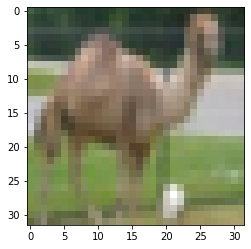

chimpanzee


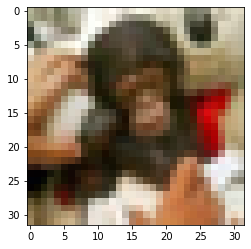

cloud


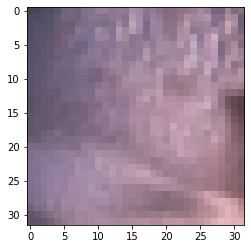

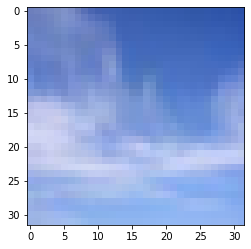

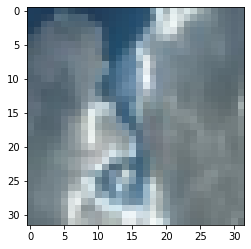

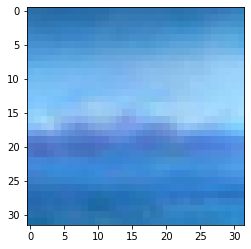

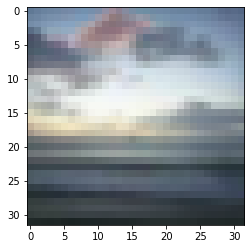

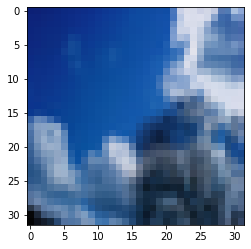

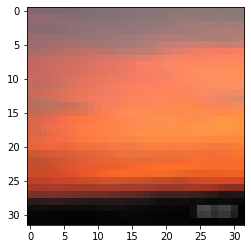

crocodile


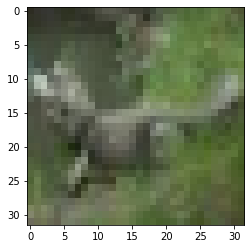

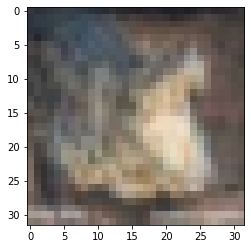

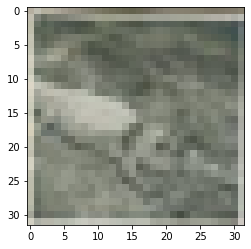

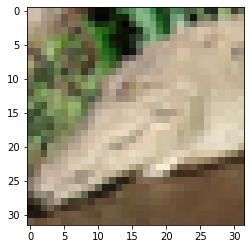

dinosaur


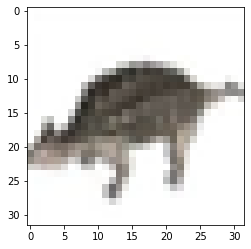

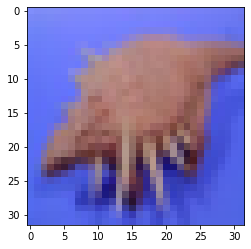

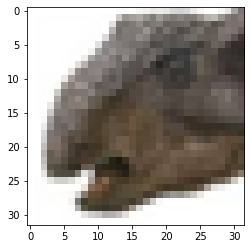

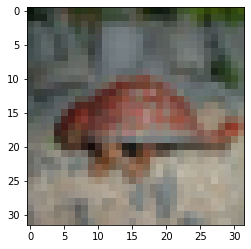

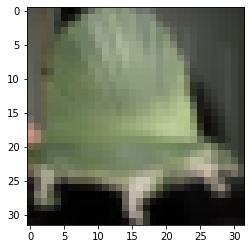

forest


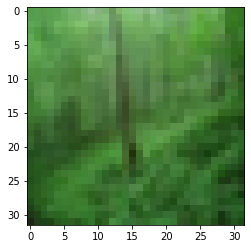

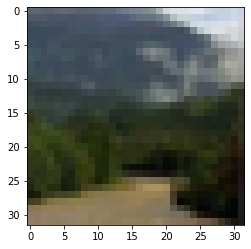

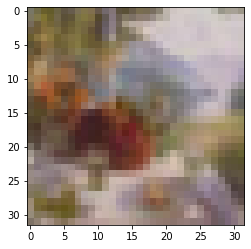

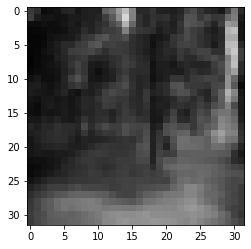

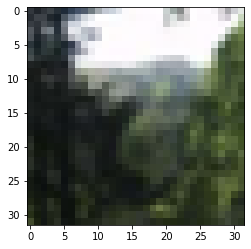

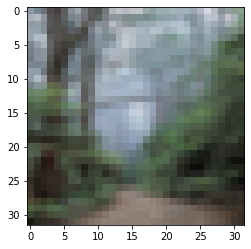

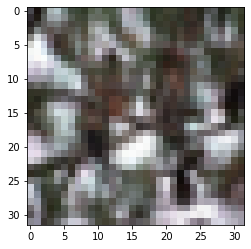

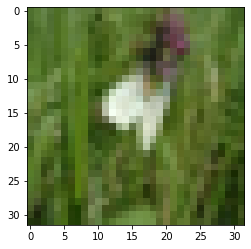

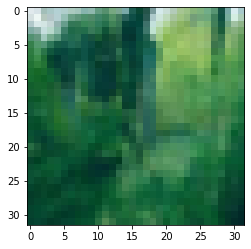

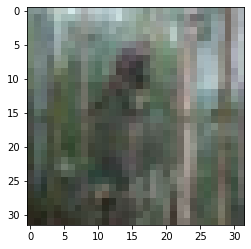

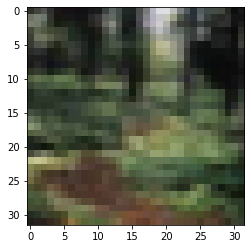

fox


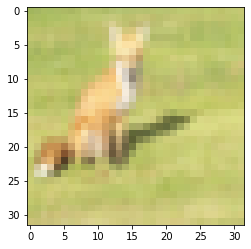

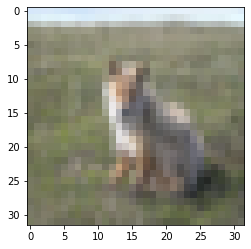

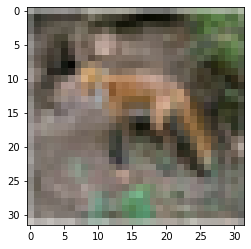

kangaroo


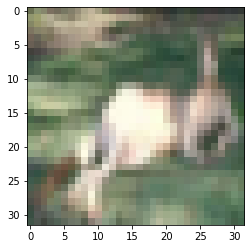

lizard


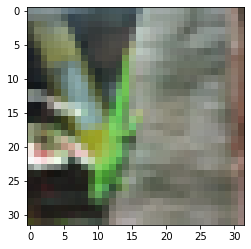

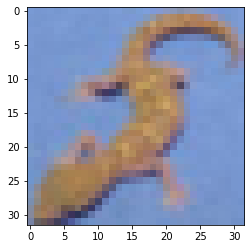

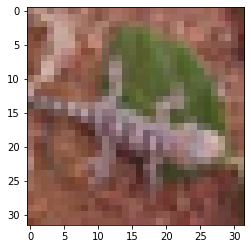

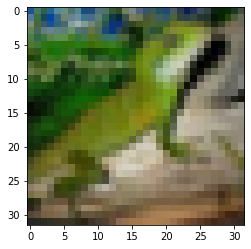

lobster


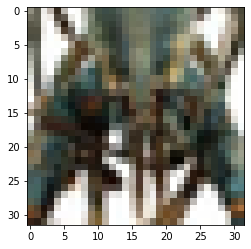

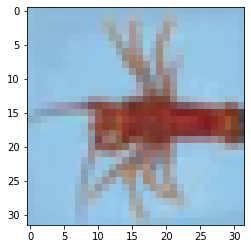

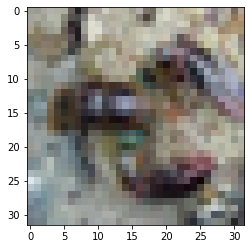

mountain


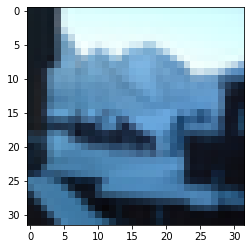

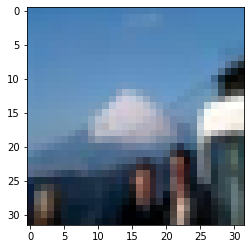

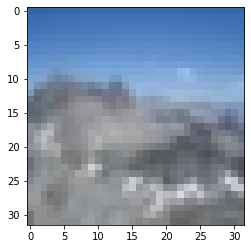

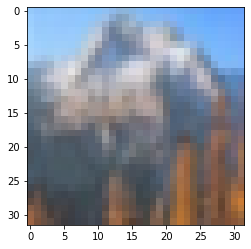

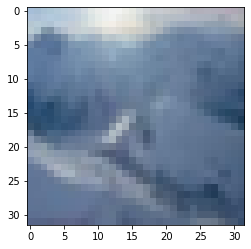

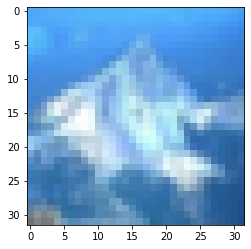

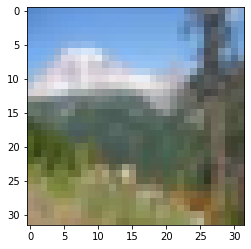

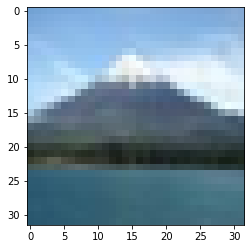

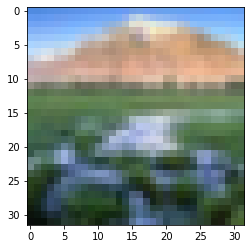

mushroom


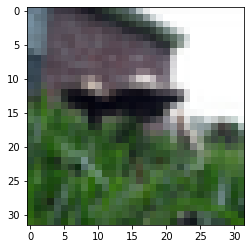

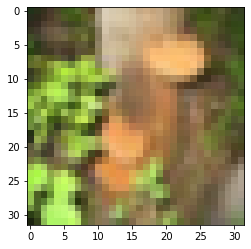

plain


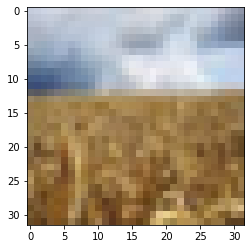

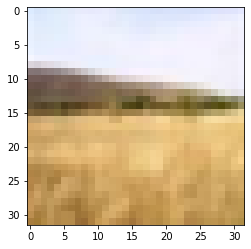

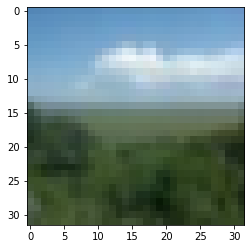

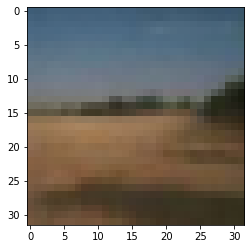

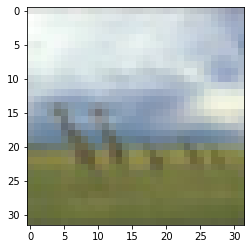

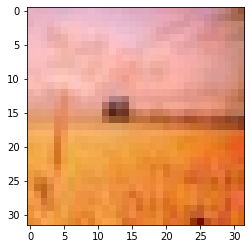

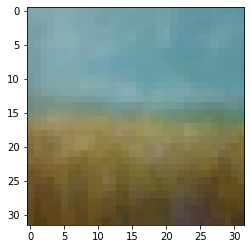

porcupine


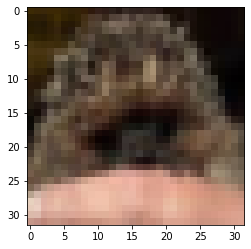

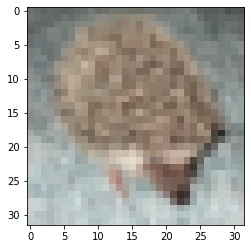

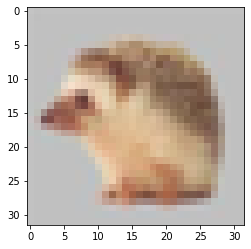

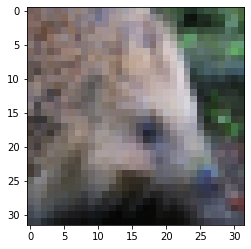

possum


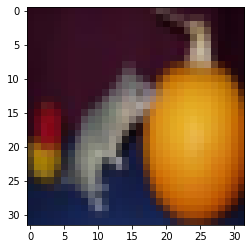

sea


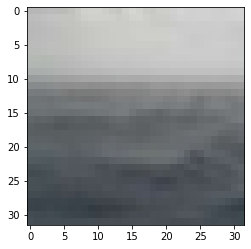

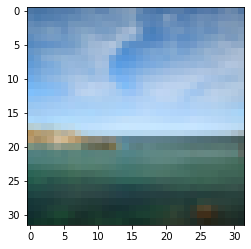

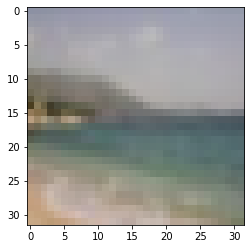

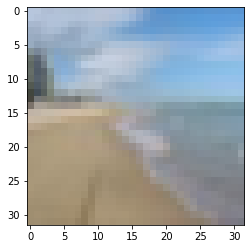

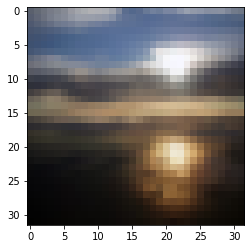

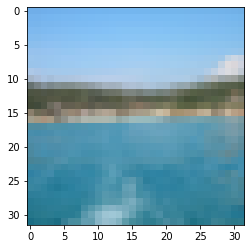

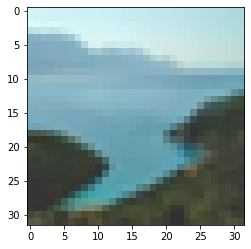

skunk


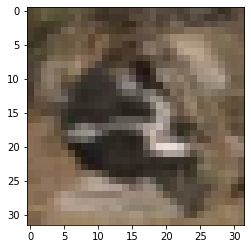

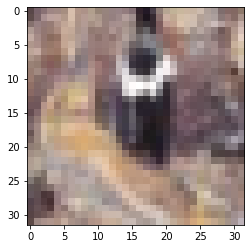

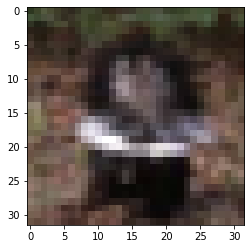

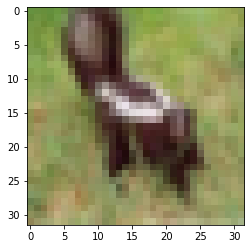

snail


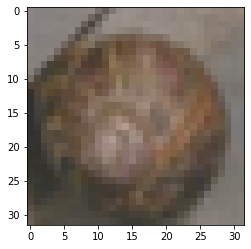

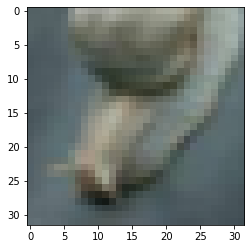

tiger


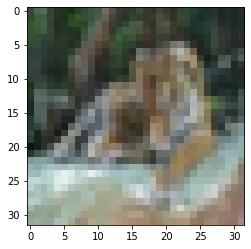

turtle


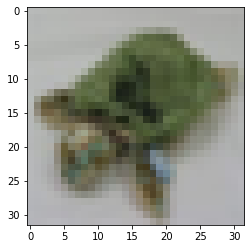

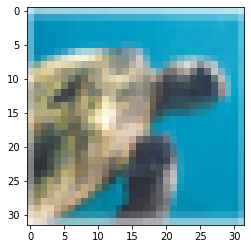

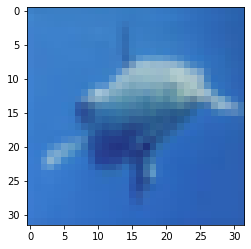

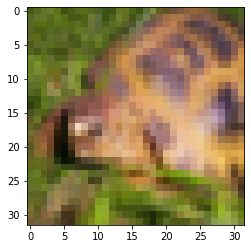

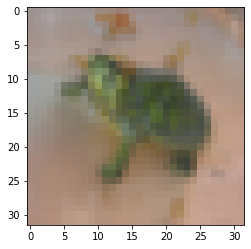

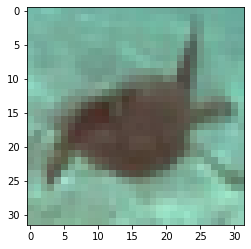

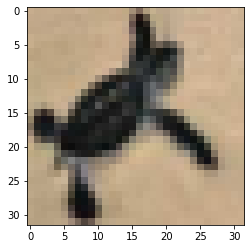

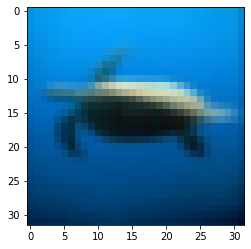

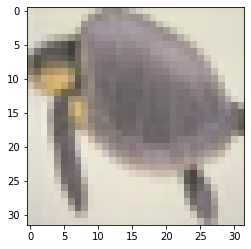

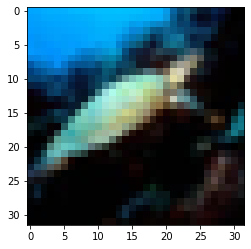

worm


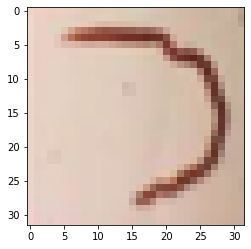

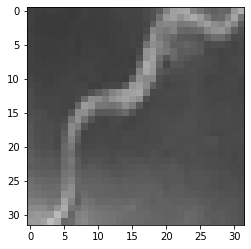

In [47]:
import matplotlib.pyplot as plt
import numpy as np

sort = np.argsort(train_data['0']['y'])
y_sorted = np.array(train_data['0']['y'])[sort]
x_sorted = np.array(train_data['0']['x'])[sort]

last_y = 10000
for i in range(y_sorted.shape[0]):
    if y_sorted[i] != last_y:
        print(fine_labels[y_sorted[i]])
        last_y = y_sorted[i]
    plt.imshow(x_sorted[i])
    plt.show()

# Test Cluster Pureness

In [32]:
from functools import reduce

In [45]:
cluster_purities = {cluster_id: [] for cluster_id in np.unique(np.array(list(train_cluster_ids_dict.values())))}

for client_id in train_clients:
    num_cluster_samples = sum(np.array(cluster_labels[client_id]) == train_cluster_ids_dict[client_id])
    cluster_purities[train_cluster_ids_dict[client_id]].append(num_cluster_samples / 100)

mean_cluster_purities = {cluster_id: (np.mean(purities), np.std(purities)) for cluster_id, purities in cluster_purities.items()}
print(mean_cluster_purities)

{0: (0.5019230769230769, 0.14250557966860944), 1: (0.46935483870967737, 0.1254137792468355), 2: (0.504, 0.1561793840428371), 3: (0.5646153846153845, 0.18566369035748417), 4: (0.5272413793103449, 0.1822823984111228), 5: (0.5246153846153847, 0.22158920359062845), 6: (0.5265384615384614, 0.19544706754775767), 7: (0.5421739130434784, 0.14852774654381495), 8: (0.6204761904761904, 0.22470035476853742), 9: (0.4651851851851852, 0.15821622266333688), 10: (0.5418181818181819, 0.20818777284060316), 11: (0.5004, 0.17516803361344216), 12: (0.5485714285714286, 0.13635687470352043), 13: (0.5338461538461539, 0.16469264901340694), 14: (0.4955555555555555, 0.18497914463694895), 15: (0.4869230769230769, 0.12754393604284672), 16: (0.5113043478260869, 0.17288609841330413), 17: (0.5492307692307692, 0.16842992327153283), 18: (0.6047058823529412, 0.17503336310741457), 19: (0.5485185185185185, 0.16388125112983268)}


In [48]:
all_cluster_purities = reduce(lambda x, y: x + y, list(cluster_purities.values()))
total_cluster_purity = (np.mean(all_cluster_purities), np.std(all_cluster_purities))
print(total_cluster_purity)

(0.5251199999999999, 0.176227652767663)
